In [363]:
# Import necessary libraries
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob


def get_measurement(file_dir):

    # Specify the directory containing the .fit files (replace with your actual path)
    file_paths = sorted(glob.glob(file_dir + "*.fit"))

    # Initialize lists to store combined data and time axis
    combined_data = []
    time_offset = 0  # To manage time axis across multiple files
    time_axes = []  # To concatenate time axes properly

    # Loop through each .fit file
    for file_path in file_paths:
        hdul = fits.open(file_path)
        
        # Access data (assuming it's a 2D array with shape [frequency, time])
        data = hdul[0].data
        
        # Extract time axis (dummy axis if not provided in the header)
        time_axis = np.arange(data.shape[1]) + time_offset
        time_axes.append(time_axis)
        
        # Append data to the combined list
        combined_data.append(data)
        
        # Update time offset for the next file
        time_offset += data.shape[1]
        
        # Close the file
        hdul.close()

    # Concatenate all data and time axes
    combined_data = np.hstack(combined_data)  # Combine along the time axis
    time_axis_combined = np.hstack(time_axes)  # Combined time axis
    freq_axis = np.arange(combined_data.shape[0])  # Dummy frequency axis

    return time_axis_combined, freq_axis, combined_data






In [364]:

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

def savgol_smooth(data, window_length=5, poly_order=2):
    """
    Smooths a 2D array along the first axis using the Savitzky-Golay filter.

    Parameters:
        data (ndarray): 2D array to be smoothed.
        window_length (int): Length of the filter window (must be odd).
        poly_order (int): Polynomial order to fit.

    Returns:
        ndarray: Smoothed 2D array.
    """
    smoothed_data = np.apply_along_axis(
        lambda x: savgol_filter(x, window_length=window_length, polyorder=poly_order),
        axis=0,
        arr=data
    )
    return smoothed_data



def gaussian(x, I, mu, sigma, A, B):
    return I * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + A*x + B


def theoretical_fit(x, S, V, omega, delta):
    return S*(1+V*np.sin(omega*x+delta))






In [365]:
def get_V_Bl_fromOneChannel(time, data, freq=0, measurement=0, printbool=False):
    try:
        if printbool:
            print(f"Measurement {measurement}, Channel {freq}")

        # Apply smoothing
        data = savgol_smooth(data, window_length=500, poly_order=3)

        # Fit the Gaussian function (using example Gaussian-like data)
        gaussian_params, _ = curve_fit(gaussian, time, data, p0=[17.5, 5720, 4640, 0, 140])
        I, mu, sigma, A, B = gaussian_params

        # Generate fitted values for plotting
        fitted_gaussian_linear = gaussian(time, I, mu, sigma, A, B)
        fitted_gaussian = gaussian(time, I, mu, sigma, 0, 0)
        linear = A*time + B

        if printbool:
            plt.plot(time, data, label="Data", color="green")
            plt.plot(time, fitted_gaussian_linear, label=f"Gaussian+linear fit: I={I:.2f}, μ={mu:.2f}, σ={sigma:.2f}, A={A:.2f}B={B:.2f}", color="purple")
            plt.title(f"Gaussian + Linear Fit; Measurement {measurement}, Channel {freq}")
            plt.xlabel("Time")
            plt.ylabel("Data")
            plt.legend()

            plt.tight_layout()
            plt.show()


            plt.plot(time, fitted_gaussian, label="Gaussian", color="green")
            #plt.plot(time, linear, label=f"Fit: A={A:.2f}, B={B:.2f}, ", color="purple")
            plt.title(f"Gaussian Part of the Fit; Measurement {measurement}, Channel {freq}")
            plt.xlabel("Time")
            plt.ylabel("Data")
            plt.legend()

            plt.tight_layout()
            plt.show()


        data = data - linear
        data = data/fitted_gaussian


        fit_params, pcov = curve_fit(theoretical_fit, time, data, p0=[1, 0.035, 0.0043, 5.6])
        S, V, omega, delta = fit_params
        std = np.sum(np.sqrt(np.diag(pcov)))

        if printbool:
            # Generate fitted values for plotting
            fitted = theoretical_fit(time, S, V, omega, delta)
            plt.plot(time, data, label="(Data-Linear)/Gaussian", color="green")
            plt.plot(time, fitted, label=f"Fit", color="purple")
            plt.title(f"Fit; Measurement {measurement}, Channel {freq}")
            plt.xlabel("Time")
            plt.ylabel("Data")
            plt.legend()

            plt.tight_layout()
            plt.show()

   
        
        if (std < 0.05):
            print(f"accepted measurement {measurement}, channel {freq}")
            """
            fitted = theoretical_fit(time, S, V, omega, delta)
            plt.plot(time, data, label="(Data-Linear)/Gaussian", color="green")
            plt.plot(time, fitted, label=f"Fit", color="purple")
            plt.title(f"Fit std={std:.4f}; Measurement {measurement}, Channel {freq}")
            plt.xlabel("Time")
            plt.ylabel("Data")
            plt.legend()

            plt.tight_layout()
            plt.show()
            """
            return abs(V), abs(omega/(2*np.pi) * 24*60*60)
        
        else:
            print(f"not accepted measurement {measurement}, channel {freq}")
            return 0,0
        

    except Exception as e:
        # Log the exception for debugging purposes if needed
        print(f"Fit failed at measurement {measurement}, channel {freq}: {e}")
        return 0, 0







In [366]:

# Directories for measurements
file_dirs = [
    "sun_meas_25/meas_1/",
    "sun_meas_25/meas_2/",
    "sun_meas_25/meas_3/",
    "sun_meas_25/meas_4/",
    "sun_meas_25/meas_5/",
    "sun_meas_25/meas_6/",
    "sun_meas_25/meas_7/"
]

# Load measurements
measurements = [get_measurement(file_dir) for file_dir in file_dirs]
# Each element of measurements is (time, freq, data)

# Prepare storage for results
results = []
for file_index, (time, freq, data) in enumerate(measurements):
    visibilities = np.empty(len(freq), dtype=float)
    Bl = np.empty(len(freq), dtype=float)

    for i, freq in enumerate(np.arange(0,121)):
        visibilities[i], Bl[i] = get_V_Bl_fromOneChannel(time, data[i], freq, file_index+1)

    results.append((visibilities, Bl))





accepted measurement 1, channel 0
accepted measurement 1, channel 1
accepted measurement 1, channel 2
accepted measurement 1, channel 3
accepted measurement 1, channel 4
accepted measurement 1, channel 5
accepted measurement 1, channel 6
accepted measurement 1, channel 7
accepted measurement 1, channel 8
accepted measurement 1, channel 9
accepted measurement 1, channel 10
accepted measurement 1, channel 11
accepted measurement 1, channel 12
accepted measurement 1, channel 13
accepted measurement 1, channel 14
accepted measurement 1, channel 15
accepted measurement 1, channel 16
not accepted measurement 1, channel 17
accepted measurement 1, channel 18
accepted measurement 1, channel 19
accepted measurement 1, channel 20
accepted measurement 1, channel 21
accepted measurement 1, channel 22
accepted measurement 1, channel 23
accepted measurement 1, channel 24
accepted measurement 1, channel 25
accepted measurement 1, channel 26
accepted measurement 1, channel 27
accepted measurement 1, ch

/tmp/ipykernel_103909/2096080027.py:42: RuntimeWarning: divide by zero encountered in divide
  data = data/fitted_gaussian
/tmp/ipykernel_103909/2096080027.py:42: RuntimeWarning: overflow encountered in divide
  data = data/fitted_gaussian


not accepted measurement 1, channel 92
accepted measurement 1, channel 93
not accepted measurement 1, channel 94
accepted measurement 1, channel 95


/tmp/ipykernel_103909/2096080027.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  gaussian_params, _ = curve_fit(gaussian, time, data, p0=[17.5, 5720, 4640, 0, 140])
/tmp/ipykernel_103909/2096080027.py:45: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_params, pcov = curve_fit(theoretical_fit, time, data, p0=[1, 0.035, 0.0043, 5.6])


not accepted measurement 1, channel 96
Fit failed at measurement 1, channel 97: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at measurement 1, channel 98: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
accepted measurement 1, channel 99
not accepted measurement 1, channel 100
Fit failed at measurement 1, channel 101: array must not contain infs or NaNs
Fit failed at measurement 1, channel 102: array must not contain infs or NaNs
accepted measurement 1, channel 103
Fit failed at measurement 1, channel 104: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit failed at measurement 1, channel 105: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit failed at measurement 1, channel 106: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.
Fit failed at measurement 1, channel 107: Optimal parameters 

/home/vinzenz/anaconda3/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1003: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/home/vinzenz/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


not accepted measurement 5, channel 67
not accepted measurement 5, channel 68
Fit failed at measurement 5, channel 69: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at measurement 5, channel 70: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at measurement 5, channel 71: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at measurement 5, channel 72: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
Fit failed at measurement 5, channel 73: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
not accepted measurement 5, channel 74
Fit failed at measurement 5, channel 75: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.
not accepted measurement 5, channel 76
not accepted measurement 5, channel 77
not accepted measurement 5, channel 78
not accept

'\n# Filter out (0, 0) values for all four channels\nvalid_indices_1 = [(omega, visibility) for omega, visibility in zip(Bl_1, visibilities_1) if not (abs(omega) < 1e-2 and abs(visibility) <1e-2)]\nfiltered_Bl_1, filtered_visibilities_1 = zip(*valid_indices_1) if valid_indices_1 else ([], [])\n\nvalid_indices_2 = [(omega, visibility) for omega, visibility in zip(Bl_2, visibilities_2) if not (abs(omega) < 1e-2 and abs(visibility) <1e-2)]\nfiltered_Bl_2, filtered_visibilities_2 = zip(*valid_indices_2) if valid_indices_2 else ([], [])\n\nvalid_indices_3 = [(omega, visibility) for omega, visibility in zip(Bl_3, visibilities_3) if not (abs(omega) < 1e-2 and abs(visibility) <1e-2)]\nfiltered_Bl_3, filtered_visibilities_3 = zip(*valid_indices_3) if valid_indices_3 else ([], [])\n\n#valid_indices_4 = [(omega, visibility) for omega, visibility in zip(Bl_4, visibilities_4) if not (abs(omega) < 1e-2 and abs(visibility) <1e-2)]\n#filtered_Bl_4, filtered_visibilities_4 = zip(*valid_indices_4) if va

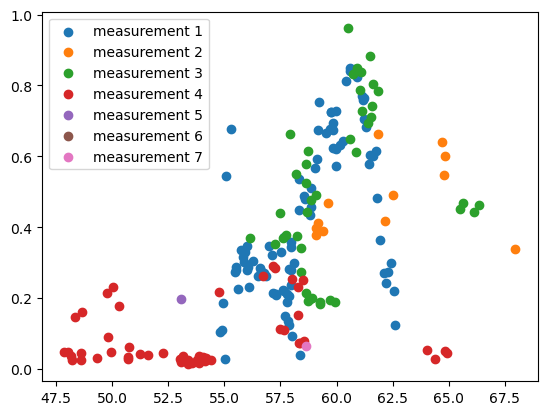

In [367]:


for index, (visibilities, Bl) in enumerate(results):
    valid_indices =[(b, v) for b, v in zip(Bl, visibilities) if not (abs(b) < 1e-2 or abs(v) <1e-2 or abs(b)>200)]
    bs, vs = zip(*valid_indices) if valid_indices else ([],[])
    plt.scatter(bs, vs, label=f"measurement {index+1}")

plt.legend()

"""
# Filter out (0, 0) values for all four channels
valid_indices_1 = [(omega, visibility) for omega, visibility in zip(Bl_1, visibilities_1) if not (abs(omega) < 1e-2 and abs(visibility) <1e-2)]
filtered_Bl_1, filtered_visibilities_1 = zip(*valid_indices_1) if valid_indices_1 else ([], [])

valid_indices_2 = [(omega, visibility) for omega, visibility in zip(Bl_2, visibilities_2) if not (abs(omega) < 1e-2 and abs(visibility) <1e-2)]
filtered_Bl_2, filtered_visibilities_2 = zip(*valid_indices_2) if valid_indices_2 else ([], [])

valid_indices_3 = [(omega, visibility) for omega, visibility in zip(Bl_3, visibilities_3) if not (abs(omega) < 1e-2 and abs(visibility) <1e-2)]
filtered_Bl_3, filtered_visibilities_3 = zip(*valid_indices_3) if valid_indices_3 else ([], [])

#valid_indices_4 = [(omega, visibility) for omega, visibility in zip(Bl_4, visibilities_4) if not (abs(omega) < 1e-2 and abs(visibility) <1e-2)]
#filtered_Bl_4, filtered_visibilities_4 = zip(*valid_indices_4) if valid_indices_4 else ([], [])

# Plot the filtered data for all four channels
plt.scatter(filtered_Bl_1, filtered_visibilities_1, label="Channel 1")
plt.scatter(filtered_Bl_2, filtered_visibilities_2, label="Channel 2")
plt.scatter(filtered_Bl_3, filtered_visibilities_3, label="Channel 3")
#plt.plot(filtered_Bl_4, filtered_visibilities_4, label="Channel 4")

# Add labels, title, and legend
plt.xlabel("B_lambda")
plt.ylabel("Visibility")
plt.title("Visibility vs B_lambda for All Channels")
plt.legend()

# Display the plot
plt.show()"""
